In [14]:
from google.colab import drive
drive.mount('/content/drive')
! pip install configargparse
! pip install wandb
! pip install open3d
! pip install lpips

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import torch

import open3d as o3d
import os

import sys
#sys.path.append('../')
sys.path.append('drive/Othercomputers/MacBookPro/')
import Rendering.visualization as v
import utils.data as data


In [16]:
def visualize_dataset(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = data.NeRFDataset(args)
    
    '''mesh = o3d.io.read_triangle_mesh(args.mesh, print_progress=True)
    mesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)
    scene = o3d.t.geometry.RaycastingScene()
    scene.add_triangles(mesh)'''
    dataset.switch_2_xnv_dataset()

    #for subdataset in dataset.subdatasets:
    for subdataset in [d for d in dataset.subdatasets if d.name == "val"]:
        imgfiles = [os.path.join(args.dataset_path, subdataset.name, f) for f in sorted(os.listdir(os.path.join(args.dataset_path, subdataset.name))) if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')]

        for i in range(subdataset.n_images):
            xnv, img, depths = dataset.get_X_target(subdataset.name, i, device=device)
            v.dataset_view_rgb_xnv(img.detach().cpu(), 
                                    (dataset.hwf[0], dataset.hwf[1], 3), 
                                    xnv[..., :3].detach().cpu(), 
                                    xnv[..., 3:6].detach().cpu(), 
                                    xnv[..., 6:].detach().cpu())

In [17]:
class Args:
    def __init__(self):
        self.mesh_path = "drive/Othercomputers/MacBookPro/lego/meshed-poisson.ply" #"../data/lego_llff/meshed-delaunay.ply"
        self.dataset_path = "drive/Othercomputers/MacBookPro/lego" #"../data/lego_llff"
        self.dataset_type = "llff"
        self.factor = 1
        self.batch_size = 8192
        self.shuffle = True
        self.test = True
        self.dataset_to_gpu = False
        self.train_images=0
        self.val_images = 20
        self.test_images= 0

visualize_dataset(Args())


Output hidden; open in https://colab.research.google.com to view.

In [175]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def crop_image(path, saveas):
    img = cv2.imread(path)
    #img = np.concatenate((np.zeros((32, 550, 3), dtype=np.uint8), img[:,125:675,:], np.zeros((32, 550, 3), dtype=np.uint8)))
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im = Image.fromarray(img[150:450,200:500])
    im.save(saveas)
    plt.imshow(im)
    plt.show()
    

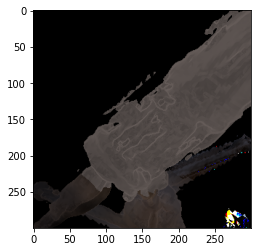

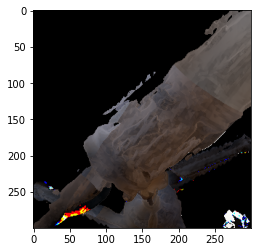

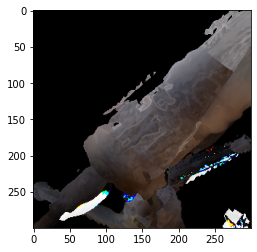

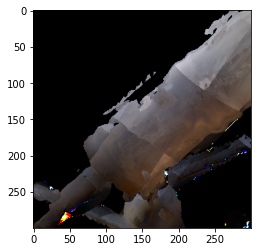

In [178]:
for i in [8, 64, 125, 512]: 
    crop_image(f'../Rendering/out/voxelised_radiance_microphone/val_xnv_pred_it{i}.png',
            f'../Rendering/out/voxelised_radiance_microphone/val_zoom_{i}voxels.png')

In [185]:
import torch
weights = torch.arange(24).reshape((4,6)).T
input = torch.arange(4).reshape((1, 4))
print(weights)
print(input)
color = input @ weights.T
print(color)
print(color[::3])
print(color.reshape([-1, 3]))

tensor([[ 0,  6, 12, 18],
        [ 1,  7, 13, 19],
        [ 2,  8, 14, 20],
        [ 3,  9, 15, 21],
        [ 4, 10, 16, 22],
        [ 5, 11, 17, 23]])
tensor([[0, 1, 2, 3]])
tensor([[ 84,  90,  96, 102, 108, 114]])
tensor([[ 84,  90,  96, 102, 108, 114]])
tensor([[ 84,  90,  96],
        [102, 108, 114]])
